In [34]:
import numpy as np 
import pandas as pd
  
import os 
print(os.listdir('/content/drive/MyDrive/CoinChecker'),'\n')
data_root = '/content/drive/MyDrive/CoinChecker'

['input1.jpg', 'README.md', 'coins_dataset', 'val', 'train', 'unknown', 'test', 'input2.jpg', 'input3.jpg', 'input4.jpg', 'coin_roi_pictures', 'HoughCircles_example.ipynb', 'coins-v1.pth', 'CoinCounter.ipynb', 'CoinClassifier_train.ipynb', 'image5.jpg', 'image6.jpg'] 



In [35]:
! pip install albumentations==0.4.6



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!ls


drive  sample_data  submission.csv  train  val


In [38]:
import shutil 
from tqdm import tqdm

train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель 
 
class_names = ['10_rubles', '1_rubles', '2_rubles', '5_rubles']
 
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 19/19 [00:00<00:00, 334.13it/s]


In [39]:
# Аугментация данных

import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ################
#    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ##############
#    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])   

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ##############
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ##########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ##########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95), 
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                         
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), #########
    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                                           
                     }
 
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)
#train_dataset = torchvision.datasets.ImageFolder(train_dir, dataset_transforms)
#val_dataset = torchvision.datasets.ImageFolder(val_dir, dataset_transforms)


batch_size = 16 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:689: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

Output hidden; open in https://colab.research.google.com to view.

In [41]:
model = models.resnet152(pretrained=True) #Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet
          
# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in model.parameters(): #Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
    param.requires_grad = False #Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать.
    
#Меняем последний полносвязанный слой, в ResNet он классифицирует на тысячу классов, а у нас класса всего 4 (будет 5!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!).
model.fc = torch.nn.Linear(model.fc.in_features, 4) # Cоздадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model fc_in features. И он единсвенный - разморожен.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
 
#Определяем Loss функцию
#В данном случае - это кросс-энтропия CrossEntropyLoss (у нас всего 2 класса) !!!!!!!!!!!!!!!!!!!!!!!!!!
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска Adam
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001) #lr - (learning rate - шаг градиентного спуска)
# Уменьшаем шаг градиентного спуска каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [42]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [43]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=40); #Запуск функции Train (Модель= ResNet,Loss-функция= CrossEntropyLoss(бинарная кросс-энтропия),Метод градиентного спуска= Adam, Уменьшение градиентного спуска в зависимости от кол-ва эпох, Кол-во эпох= 30) )

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/40:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.6592 Acc: 0.2656 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.4491 Acc: 0.2857 Epoch 2/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.4246 Acc: 0.2500 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.4616 Acc: 0.3571 Epoch 3/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.2629 Acc: 0.4062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.1187 Acc: 0.5000 Epoch 4/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.0216 Acc: 0.5938 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.1167 Acc: 0.5714 Epoch 5/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.0052 Acc: 0.6094 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.9795 Acc: 0.5000 Epoch 6/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8306 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8801 Acc: 0.7857 Epoch 7/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8584 Acc: 0.7344 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.9097 Acc: 0.7857 Epoch 8/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7779 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8727 Acc: 0.9286 Epoch 9/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8083 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8871 Acc: 0.7143 Epoch 10/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7699 Acc: 0.8906 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7994 Acc: 0.7857 Epoch 11/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8583 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8391 Acc: 0.7143 Epoch 12/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7804 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8560 Acc: 0.7857 Epoch 13/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8304 Acc: 0.7188 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8634 Acc: 0.7857 Epoch 14/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7785 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8963 Acc: 0.7857 Epoch 15/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7561 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7899 Acc: 0.7857 Epoch 16/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8062 Acc: 0.8125 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.9027 Acc: 0.7143 Epoch 17/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7706 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8264 Acc: 0.8571 Epoch 18/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7674 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8332 Acc: 0.7857 Epoch 19/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7953 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8751 Acc: 0.7143 Epoch 20/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7997 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8218 Acc: 0.8571 Epoch 21/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7745 Acc: 0.7188 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7847 Acc: 0.8571 Epoch 22/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8178 Acc: 0.8281 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8669 Acc: 0.7857 Epoch 23/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7718 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8444 Acc: 0.7857 Epoch 24/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8100 Acc: 0.8125 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7385 Acc: 0.9286 Epoch 25/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7381 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8294 Acc: 0.9286 Epoch 26/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8208 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8212 Acc: 0.8571 Epoch 27/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8150 Acc: 0.8281 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7675 Acc: 0.8571 Epoch 28/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7492 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.9314 Acc: 0.7143 Epoch 29/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8426 Acc: 0.8125 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8729 Acc: 0.7143 Epoch 30/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7754 Acc: 0.8281 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8308 Acc: 0.8571 Epoch 31/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7686 Acc: 0.7969 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7808 Acc: 0.8571 Epoch 32/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7833 Acc: 0.7812 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8383 Acc: 0.7857 Epoch 33/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7568 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8251 Acc: 0.7143 Epoch 34/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7510 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8376 Acc: 0.7857 Epoch 35/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7709 Acc: 0.9531 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8757 Acc: 0.8571 Epoch 36/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7953 Acc: 0.7969 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8573 Acc: 0.7143 Epoch 37/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7453 Acc: 0.8594 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8545 Acc: 0.8571 Epoch 38/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8055 Acc: 0.9531 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.8108 Acc: 0.8571 Epoch 39/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7953 Acc: 0.7969 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7668 Acc: 0.8571 Epoch 40/40:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.8066 Acc: 0.8438 

100%|██████████| 1/1 [00:07<00:00,  8.00s/it]

val Loss: 0.8955 Acc: 0.8571 

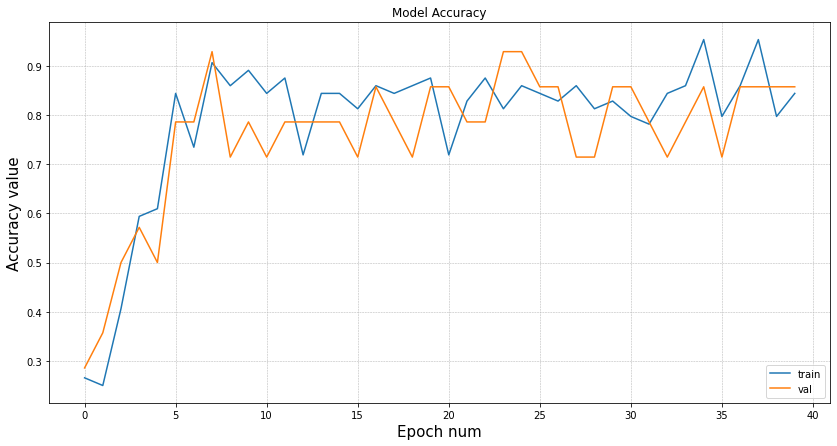

In [44]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id, linewidth=1.5)
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

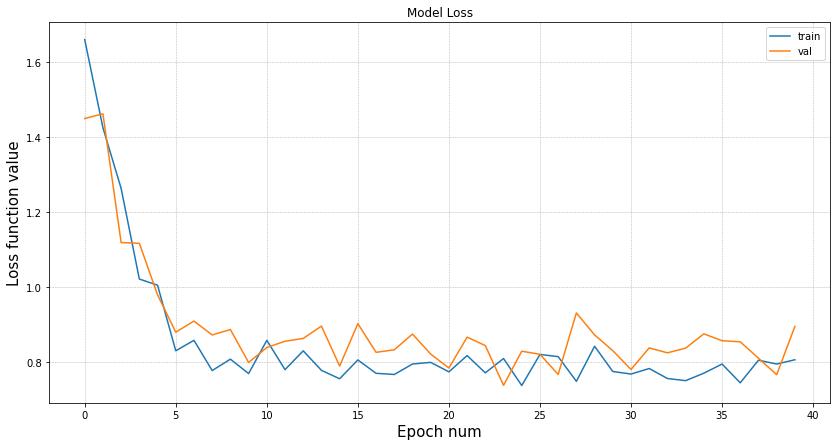

In [45]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id, linewidth=1.5)
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [46]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
if not os.path.isdir(os.path.join(data_root,'coins_dataset','test', 'unknown')):
    #shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
    shutil.copytree(os.path.join(data_root,'coins_dataset', 'test'), os.path.join(data_root,'coins_dataset','test', 'unknown'))

In [47]:
print(os.path.join(data_root, 'unknown'))
os.path.join(data_root, 'test')

/content/drive/MyDrive/CoinChecker/unknown


'/content/drive/MyDrive/CoinChecker/test'

In [48]:
print(os.path.isdir(os.path.join(data_root, 'unknown')))

True


In [49]:
#%cd /content/drive/MyDrive/CoinChecker/test
!ls


drive  sample_data  submission.csv  train  val


In [50]:
#Мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч".
#Они по алфавиту идут, по дате создания, или просто случайным образом -- непонятно.
#Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): #Создаем класс, он наследуется от ImageFolder, но изменяет его функцию get_item
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) #Дополняем original_tuple путем для файла (.__getitem__(index))
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
df = pd.DataFrame
#Итерируемся по Crop'ам test датасета
for (i,tranforms) in dataset_transforms.items():
    #test_dataset = ImageFolderWithPaths('/kaggle/working/test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataset = ImageFolderWithPaths('/content/drive/MyDrive/CoinChecker/coins_dataset/test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений
    
    model.eval() #Переводим модель в состояние eval
    test_predictions = []  #Создаем пустой список предсказания 
    test_img_paths = [] #Пути до изображения
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения  
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
#####            print(torch.nn.functional.softmax(preds, dim=1)) ####################
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()) #С помощью torch.nn.functional.softmax получаем вероятности, для первого класса [:,1], пеереводим тензор в .data, на .cpu(), в numpy 
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)
    
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, class_names[0]: test_predictions[:, 0]}) #####
    
    submission_df[class_names[1]] = test_predictions[:, 1]
    submission_df[class_names[2]] = test_predictions[:, 2]
    submission_df[class_names[3]] = test_predictions[:, 3]
    
    submission_df['id'] = submission_df['id'].str.replace('/content/drive/MyDrive/CoinChecker/coins_dataset/test/unknown', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    
    try : df = df.merge(submission_df, how='inner', on='id') #Объединяем в один датафрейм
    except BaseException: # Для первой итерации
        df = submission_df 
    #submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    #submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df.head(8)

100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y,10_rubles_x,1_rubles_x,2_rubles_x,5_rubles_x,10_rubles_y,1_rubles_y,2_rubles_y,5_rubles_y
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/content/drive/MyDrive/CoinChecker/coins_dataset/test/10_rubles/009__10 Rubles_russia,0.517115,0.198100,0.153814,0.130971,0.614670,0.046339,0.014769,0.324222,0.721717,0.044094,0.013973,0.220217,0.575697,0.071677,0.031053,0.321573,0.703593,0.091393,0.041020,0.163995,0.693297,0.113813,0.095448,0.097442,0.611936,0.130443,0.155283,0.102339,0.739304,0.104785,0.079280,0.076632,0.704652,0.091244,0.084607,0.119497,0.668322,0.137251,0.100376,0.094051,0.586851,0.134118,0.142505,0.136526,0.557830,0.189827,0.137666,0.114677,0.658099,0.156109,0.099898,0.085894,0.447162,0.247492,0.188892,0.116454,0.448449,0.287222,0.168738,0.095591,0.438152,0.254834,0.164519,0.142496
/content/drive/MyDrive/CoinChecker/coins_dataset/test/10_rubles/012__10 Rubles_russia,0.467561,0.209121,0.163394,0.159923,0.565525,0.062161,0.020352,0.351962,0.498946,0.076396,0.030379,0.394279,0.555429,0.072044,0.038536,0.333990,0.701702,0.077257,0.025545,0.195496,0.677052,0.110042,0.031536,0.181370,0.579258,0.170111,0.154049,0.096583,0.511645,0.159692,0.113072,0.215590,0.533918,0.198610,0.156342,0.111130,0.502181,0.210962,0.157000,0.129857,0.508308,0.164953,0.162598,0.164141,0.557571,0.198321,0.138110,0.105998,0.578115,0.159488,0.135882,0.126515,0.491725,0.165772,0.178251,0.164252,0.425229,0.215039,0.194810,0.164922,0.385087,0.232318,0.177970,0.204625
/content/drive/MyDrive/CoinChecker/coins_dataset/test/10_rubles/014__10 Rubles_russia,0.508703,0.232041,0.137390,0.121866,0.441595,0.087491,0.050766,0.420149,0.586357,0.080742,0.044450,0.288451,0.530784,0.144406,0.098826,0.225984,0.657132,0.110264,0.042255,0.190348,0.563563,0.178475,0.123851,0.134110,0.585308,0.182482,0.120855,0.111355,0.498386,0.185975,0.167066,0.148574,0.449092,0.209419,0.177252,0.164237,0.532426,0.181184,0.172521,0.113869,0.509421,0.182958,0.162964,0.144657,0.468505,0.235645,0.174670,0.121180,0.524730,0.198975,0.156610,0.119685,0.401328,0.252437,0.192839,0.153396,0.350883,0.319258,0.178352,0.151507,0.430232,0.203794,0.166356,0.199618
/content/drive/MyDrive/CoinChecker/coins_dataset/test/10_rubles/017__10 Rubles_russia,0.444883,0.249882,0.170667,0.134568,0.695253,0.083241,0.026197,0.195308,0.529341,0.170794,0.117245,0.182620,0.309663,0.232410,0.270975,0.186952,0.447935,0.209964,0.140561,0.201541,0.397043,0.233055,0.209259,0.160644,0.237371,0.351269,0.243353,0.168006,0.467862,0.242856,0.154917,0.134364,0.396930,0.252926,0.189660,0.160484,0.494759,0.204690,0.124336,0.176215,0.383244,0.256553,0.194969,0.165233,0.463976,0.261297,0.162922,0.111806,0.357608,0.307487,0.210949,0.123956,0.352975,0.277919,0.196569,0.172537,0.345132,0.302330,0.176515,0.176023,0.426345,0.216610,0.165612,0.191432
/content/drive/MyDrive/CoinChecker/coins_dataset/test/1_rubles/000__1 Rubles_russia,0.054736,0.392082,0.224094,0.329087,0.407095,0.168846,0.201246,0.222814,0.405866,0.186465,0.182068,0.225601,0.387639,0.188124,0.234405,0.189832,0.426113,0.143102,0.240876,0.189908,0.330614,0.239296,0.216235,0.213855,0.385803,0.177851,0.263403,0.172942,0.344960,0.208082,0.237262,0.209696,0.361919,0.245010,0.215052,0.178019,0.381294,0.238548,0.189308,0.190851,0.365312,0.217452,0.245300,0.171936,0.387009,0.210529,0.229208,0.173253,0.385869,0.247344,0.179840,0.186947,0.462843,0.2

In [51]:
df[['avg_10', 'avg_1', 'avg_2', 'avg_5']] = df.groupby(np.arange(df.shape[1]) % 4, axis=1).mean()

In [52]:
type(df)

pandas.core.frame.DataFrame

In [53]:
res_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': ['smth'] * len(test_img_paths)})
res_df['id'] = res_df['id'].str.replace('/content/drive/MyDrive/CoinChecker/coins_dataset/test/unknown/', '')
res_df['id'] = res_df['id'].str.replace('.jpg', '')

In [54]:
for i in range(len(res_df)):
    res_df['label'][i] = (df[df.columns[-4::]]).idxmax(axis=1)[i]

In [55]:
res_df['label'] = res_df['label'].str.replace('avg_', '')

In [56]:
res_df.to_csv('submission.csv')

In [57]:
res_df['label']

0     10
1     10
2     10
3     10
4     10
5     10
6     10
7      5
8      5
9      5
10    10
11    10
12     5
13    10
14    10
15    10
16    10
17    10
18    10
19    10
20    10
21    10
22    10
23    10
24     5
25     5
26    10
27    10
28     5
29    10
30    10
31    10
Name: label, dtype: object

In [58]:
res_df['is_pred_right'] = ['NaN'] * len(res_df)

for i in range(len(res_df)):
    if res_df['id'][i][:2] == res_df['label'][i] + '_' or res_df['id'][i][:2] == res_df['label'][i]:
        res_df['is_pred_right'][i] = True
    else:
        res_df['is_pred_right'][i] = False




In [59]:
type(res_df['id'])

pandas.core.series.Series

In [60]:
accuracy = res_df['is_pred_right'].sum() / len(res_df)
accuracy

0.15625

In [64]:
torch.save(model.state_dict(), '/content/drive/My Drive/CoinChecker/coins-v2.pth')

In [62]:
#from IPython.display import FileLink
#FileLink(r'coins-v1.pth')